In [1]:
import os
import string
from collections import Counter
from datetime import datetime

import nltk
import pandas as pd
import matplotlib
import seaborn as sns
from textblob import TextBlob
from nltk.corpus import stopwords
from nltk.util import ngrams

In [2]:
%matplotlib inline
matplotlib.rcParams['figure.max_open_warning'] = 1000
matplotlib.rcParams['lines.linewidth'] = 1.0

pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [3]:
def my_ngrams(tokens, rg):
    ngrms = []
    for i in range(rg[0], rg[1] + 1):
        ngrms_aux = [ngrm for ngrm in ngrams(tokens, i)]
        ngrms.extend(ngrms_aux)
    return ngrms

# Preparing data

## Selected keywords

In [4]:
original_keywords = ["Picard", "Kirk", "Sulu", "Uhura", "Spock", "McCoy", "Bones", "Scotty", "Chekhov", "Crusher", "Nurse Chapel", "Sarek", "Nero", "Khan", "Data", "Pike", "Star Trek", "Klingon", "Vulcan", "Romulan", "Star fleet", "Starship Enterprise", "Delta Vega", "Earth", "Orion", "Romulan Narada", "Stardate", "Transporter beam", "Beam me up,\? Scotty", "Kobayashi Maru", "Space,\? The Final Frontier", "Energize", "Vulcan Salute", "Prime Directive", "Live long and prosper", "LLAP", "I'm a doctor,\? not a", "KHAAA\+N", "When you eliminate the impossible,\? whatever remains,\? however improbable,\? must be the truth", "Without followers,\? evil cannot spread", "The needs of the many outweigh the needs of the few", "Highly illogical", "to boldly go where no man has gone before", "I'm giving her all she's got,\? Captain", "Nuclear wessels", "Set phasers to stun", "Resistance is futile", "I have been and always shall be your friend"]

In [5]:
print(original_keywords)

['Picard', 'Kirk', 'Sulu', 'Uhura', 'Spock', 'McCoy', 'Bones', 'Scotty', 'Chekhov', 'Crusher', 'Nurse Chapel', 'Sarek', 'Nero', 'Khan', 'Data', 'Pike', 'Star Trek', 'Klingon', 'Vulcan', 'Romulan', 'Star fleet', 'Starship Enterprise', 'Delta Vega', 'Earth', 'Orion', 'Romulan Narada', 'Stardate', 'Transporter beam', 'Beam me up,\\? Scotty', 'Kobayashi Maru', 'Space,\\? The Final Frontier', 'Energize', 'Vulcan Salute', 'Prime Directive', 'Live long and prosper', 'LLAP', "I'm a doctor,\\? not a", 'KHAAA\\+N', 'When you eliminate the impossible,\\? whatever remains,\\? however improbable,\\? must be the truth', 'Without followers,\\? evil cannot spread', 'The needs of the many outweigh the needs of the few', 'Highly illogical', 'to boldly go where no man has gone before', "I'm giving her all she's got,\\? Captain", 'Nuclear wessels', 'Set phasers to stun', 'Resistance is futile', 'I have been and always shall be your friend']


In [6]:
ambiguous_keywords = [
    'Bones',
    'Khan',
    'Data',
    'Earth',
    'Energize',
]

In [7]:
keywords = list(set(original_keywords).difference(ambiguous_keywords))
keywords = [w.replace('\\', '').lower() for w in keywords]
keywords.sort()

In [8]:
print(keywords)

['beam me up,? scotty', 'chekhov', 'crusher', 'delta vega', 'highly illogical', 'i have been and always shall be your friend', "i'm a doctor,? not a", "i'm giving her all she's got,? captain", 'khaaa+n', 'kirk', 'klingon', 'kobayashi maru', 'live long and prosper', 'llap', 'mccoy', 'nero', 'nuclear wessels', 'nurse chapel', 'orion', 'picard', 'pike', 'prime directive', 'resistance is futile', 'romulan', 'romulan narada', 'sarek', 'scotty', 'set phasers to stun', 'space,? the final frontier', 'spock', 'star fleet', 'star trek', 'stardate', 'starship enterprise', 'sulu', 'the needs of the many outweigh the needs of the few', 'to boldly go where no man has gone before', 'transporter beam', 'uhura', 'vulcan', 'vulcan salute', 'when you eliminate the impossible,? whatever remains,? however improbable,? must be the truth', 'without followers,? evil cannot spread']


## Comments

In [9]:
%%time

dtypes = {
    'author': str,
    'body': str,
    'controversiality': int,
    'created_utc': pd.tslib.Timestamp,
    'distinguished': str,
    'downs': str,
    'gilded': str,
    'id': str,
    'name': str,
    'parent_id': str,
    'score': int,
    'subreddit': str,
    'ups': str,
    'month': pd.tslib.Timestamp,
    'year': pd.tslib.Timestamp,
}

reddit_df = pd.read_csv('reddit.csv', header=0, dtype=dtypes, parse_dates=['created_utc', 'month', 'year'])
reddit_df = reddit_df.fillna(0)

CPU times: user 29 s, sys: 1.25 s, total: 30.3 s
Wall time: 30.3 s


In [10]:
len(reddit_df)

2669814

In [11]:
reddit_df.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
0,gschizas,same in greek. my personal peeve: quite a lot ...,0,2007-10-15 15:22:33,0,0.0,0,c029c79,t1_c029c79,t1_c029brz,13,programming,13,2007-10-01,2007-01-01
1,[deleted],&gt;they also decided to rig a thermal barrier...,0,2007-10-16 05:11:09,0,0.0,0,c029g6h,t1_c029g6h,t3_5ye94,2,programming,2,2007-10-01,2007-01-01
2,johnmudd,&gt; by the time a child born today graduates ...,0,2007-10-16 07:00:36,0,0.0,0,c029gfc,t1_c029gfc,t3_5ye9w,1,science,1,2007-10-01,2007-01-01
3,feliniti,nero 8 - bloated waste of money. unless you ha...,0,2007-10-16 07:10:27,0,0.0,0,c029gge,t1_c029gge,t3_5yej4,1,reddit.com,1,2007-10-01,2007-01-01
4,masklinn,&gt; i wonder what happens if you started clea...,0,2007-10-16 11:27:15,0,0.0,0,c029hiy,t1_c029hiy,t1_c029h3y,3,reddit.com,3,2007-10-01,2007-01-01


# Analyzing data

## Score

In [12]:
P = 1

### Top

In [13]:
top_scored = reddit_df.sort_values(['score'], ascending=False)[:len(reddit_df) * P // 100]

In [14]:
len(top_scored)

26698

In [15]:
top_scored.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
2428290,Aavenell,"""it is possible to make no mistakes and lose. ...",0,2016-05-08 20:27:50,0,0,1,d2y0xkp,0,t3_4igg2s,6986,AskReddit,6986,2016-05-01,2016-01-01
1891461,Inteli_Gent,dungeons &amp; dragons - - edit: this is my h...,0,2015-08-08 22:33:05,0,0,2,ctwhrrg,0,t3_3gaz4f,6454,AskReddit,6454,2015-08-01,2015-01-01
2663053,Zorthianator,we had a guy in our class that was one of thos...,0,2016-08-29 07:11:11,0,0,0,d7123mt,0,t3_503z1d,6056,AskReddit,6056,2016-08-01,2016-01-01
1417553,acidnisibannac,"**as much as i appreciate it, i've been given ...",0,2014-11-15 13:27:31,0,0.0,6,cm3dn3j,t1_cm3dn3j,t3_2me7l2,5758,explainlikeimfive,5758,2014-11-01,2014-01-01
2624241,Sandwichofdeth,let's not forget the time star trek strapped a...,0,2016-08-11 12:13:18,0,0,0,d6ddros,0,t3_4x7vzi,5718,movies,5718,2016-08-01,2016-01-01


In [16]:
top_scored.ix[2428290]['body']

'"it is possible to make no mistakes and lose. that is not failure; that is life." -  - -cpt. jean-luc picard'

#### Temporal evolution

In [17]:
df_by_month = pd.Series(top_scored.groupby('month')['id'].count())
df_by_month.index.name = None

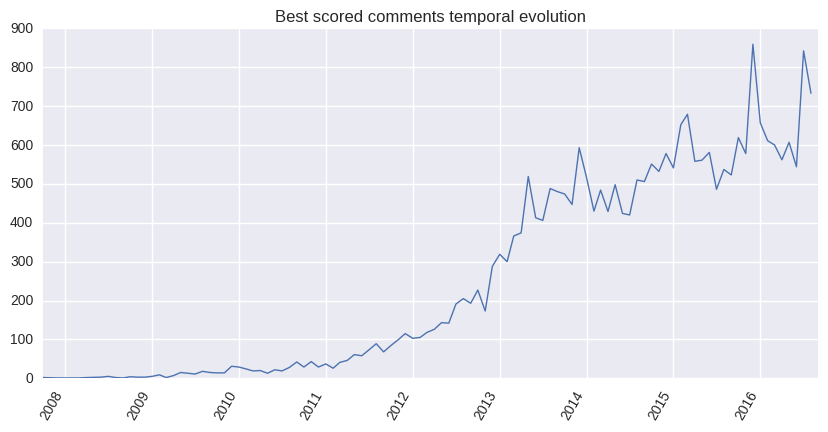

In [18]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Best scored comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [19]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = top_scored['body'].str.count(k).sum()

CPU times: user 1.92 s, sys: 3.55 ms, total: 1.92 s
Wall time: 1.92 s


In [20]:
keywords_counter = Counter(keywords_dict)

In [21]:
keywords_counter.most_common()

[('star trek', 8834),
 ('kirk', 3985),
 ('picard', 2417),
 ('mccoy', 2006),
 ('spock', 1811),
 ('pike', 1572),
 ('klingon', 1326),
 ('orion', 1304),
 ('nero', 1126),
 ('scotty', 1066),
 ('vulcan', 975),
 ('crusher', 820),
 ('prime directive', 309),
 ('chekhov', 291),
 ('romulan', 291),
 ('resistance is futile', 268),
 ('uhura', 248),
 ('sulu', 231),
 ('khaaa+n', 219),
 ('live long and prosper', 159),
 ('llap', 125),
 ('star fleet', 113),
 ('stardate', 108),
 ('starship enterprise', 100),
 ("i'm a doctor,? not a", 85),
 ('kobayashi maru', 80),
 ('beam me up,? scotty', 67),
 ('nuclear wessels', 42),
 ('the needs of the many outweigh the needs of the few', 40),
 ('highly illogical', 24),
 ('vulcan salute', 18),
 ('sarek', 18),
 ('to boldly go where no man has gone before', 14),
 ('space,? the final frontier', 12),
 ("i'm giving her all she's got,? captain", 9),
 ('transporter beam', 8),
 ('nurse chapel', 8),
 ('set phasers to stun', 5),
 ('i have been and always shall be your friend', 2),

In [22]:
keywords_sr = pd.Series(keywords_dict)

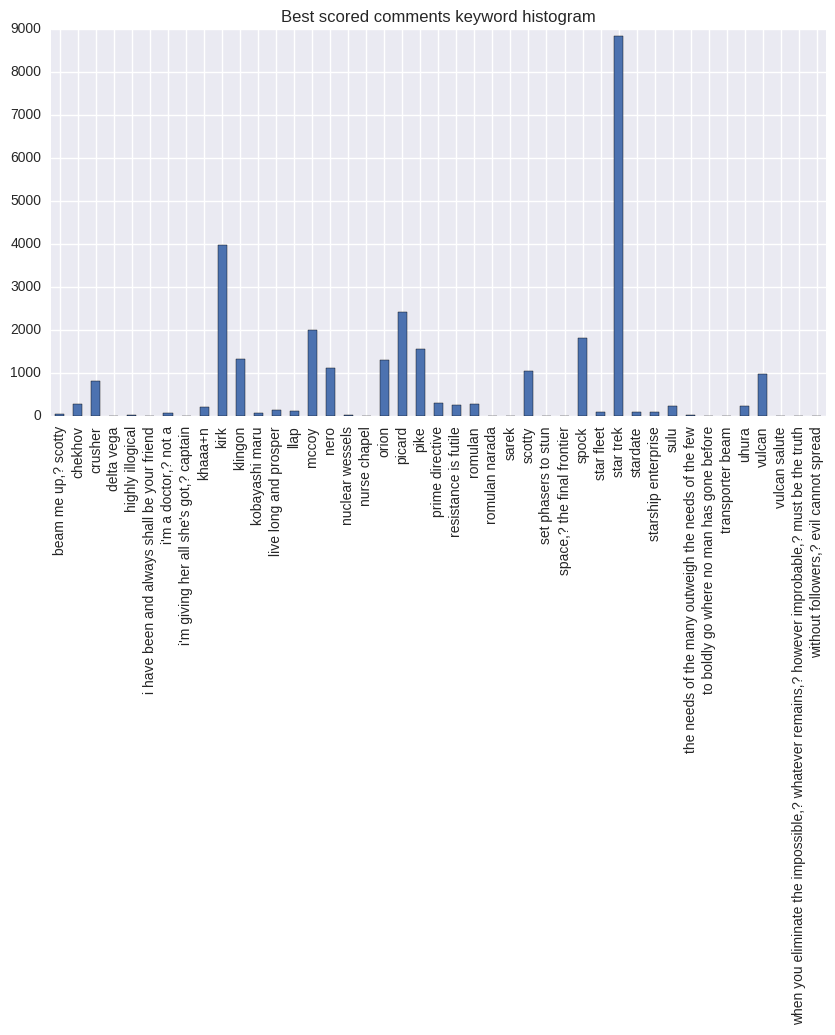

In [23]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Best scored comments keyword histogram',
)

### Bottom

In [24]:
bottom_scored = reddit_df.sort_values(['score'], ascending=True)[:len(reddit_df) * P // 100]

In [25]:
len(bottom_scored)

26698

In [26]:
bottom_scored.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
2355490,candyman420,"&gt; who knows, maybe this will even attract s...",0,2016-03-29 21:33:47,0,0,0,d1iir42,0,t1_d1id4ps,-478,startrek,-478,2016-03-01,2016-01-01
1306450,K4S3-R,"okay, this one legitimately made me laugh my a...",0,2014-09-21 16:32:35,0,0.0,0,ckop2ps,t1_ckop2ps,t1_ckooi1r,-472,AdviceAnimals,-472,2014-09-01,2014-01-01
2189904,Trentsexual,came here to downvote the first dumb and dumbe...,0,2016-01-01 20:28:23,0,0,0,cyiu3g4,0,t1_cyitxud,-442,AdviceAnimals,-442,2016-01-01,2016-01-01
1772147,Redskinsthebestskins,"dude let it go. - - we get it, eagles fans h...",0,2015-05-30 06:57:12,0,0.0,0,crpsmrl,t1_crpsmrl,t1_crpsl7d,-422,nfl,-422,2015-05-01,2015-01-01
2015006,guccigoogle,yoda is not from star trek my good sir. downvo...,0,2015-10-10 23:53:04,0,0,0,cvvhobs,0,t1_cvvfnqh,-263,funny,-263,2015-10-01,2015-01-01


In [27]:
bottom_scored.ix[2355490]['body']

"&gt; who knows, maybe this will even attract some new fans! -  - it probably won't, or not very many.  star trek is mostly for nerds. -  - edit:  that's where all of you came from, #1 post in subreddit drama!  have fun! -  - up to -91 now.  i am sure each and every one of you are following the rules to the letter. -  - let's make it a game, see if you can bring my karma below 15,000.  ready set, go! - -- - i couldn't have done it without you guys!  up to -314 now.  i'm afraid you failed the mission though.  total karma is now still at 15,107.  better luck next time."

#### Temporal evolution

In [28]:
df_by_month = pd.Series(bottom_scored.groupby('month')['id'].count())
df_by_month.index.name = None

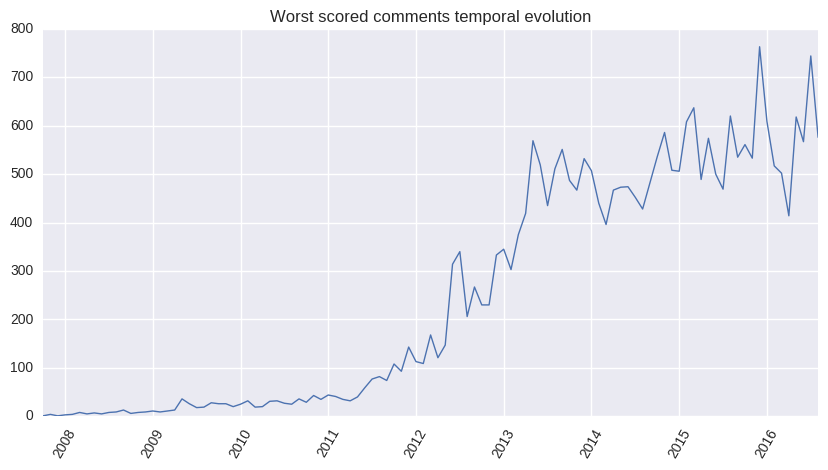

In [29]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Worst scored comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [30]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = bottom_scored['body'].str.count(k).sum()

CPU times: user 1.62 s, sys: 58 µs, total: 1.62 s
Wall time: 1.62 s


In [31]:
keywords_counter = Counter(keywords_dict)

In [32]:
keywords_counter.most_common()

[('star trek', 8339),
 ('kirk', 2454),
 ('mccoy', 2429),
 ('vulcan', 1655),
 ('orion', 1469),
 ('pike', 1414),
 ('spock', 1169),
 ('picard', 1096),
 ('nero', 794),
 ('crusher', 721),
 ('klingon', 639),
 ('scotty', 597),
 ('resistance is futile', 579),
 ('sulu', 257),
 ('prime directive', 201),
 ('romulan', 155),
 ('live long and prosper', 136),
 ('uhura', 121),
 ('chekhov', 97),
 ('the needs of the many outweigh the needs of the few', 96),
 ('highly illogical', 87),
 ('star fleet', 83),
 ('khaaa+n', 51),
 ('starship enterprise', 48),
 ('llap', 43),
 ('beam me up,? scotty', 31),
 ('kobayashi maru', 24),
 ('vulcan salute', 11),
 ('stardate', 10),
 ('sarek', 7),
 ("i'm a doctor,? not a", 6),
 ('to boldly go where no man has gone before', 4),
 ('space,? the final frontier', 3),
 ('delta vega', 3),
 ('transporter beam', 2),
 ('nuclear wessels', 2),
 ('nurse chapel', 2),
 ('i have been and always shall be your friend', 1),
 ('when you eliminate the impossible,? whatever remains,? however imp

In [33]:
keywords_sr = pd.Series(keywords_dict)

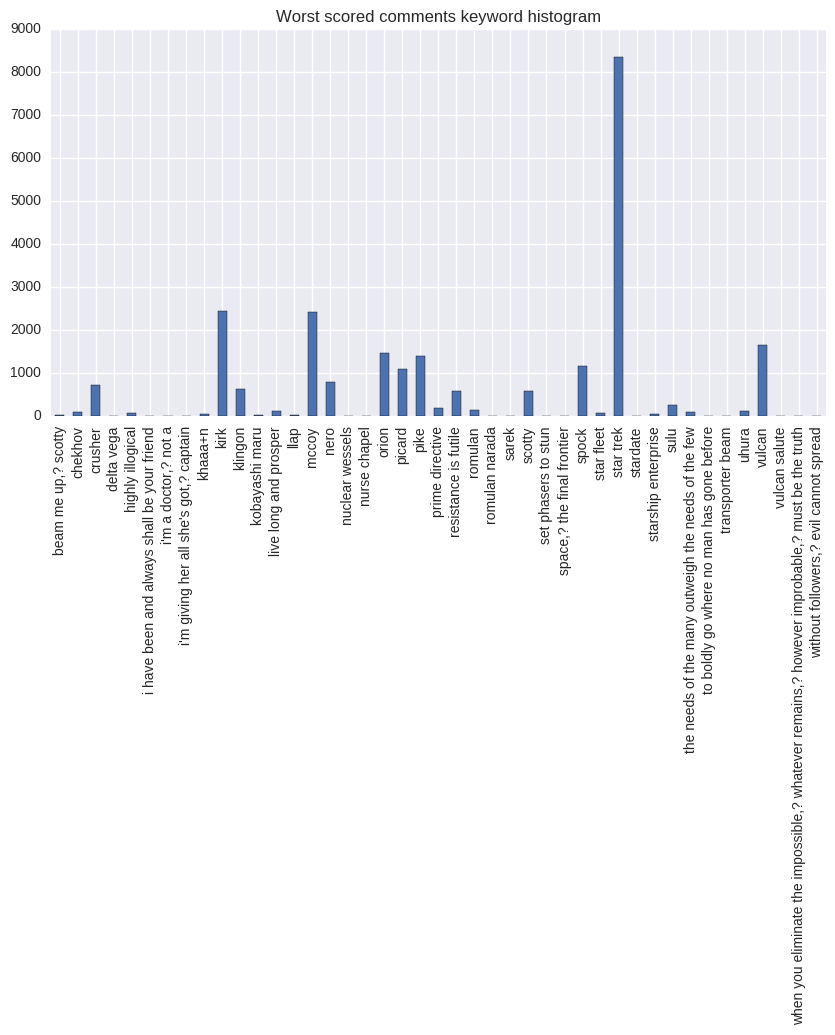

In [34]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Worst scored comments keyword histogram',
)

## Controversiality

In [35]:
controversial_df = reddit_df[reddit_df['controversiality'] == 1]

In [36]:
len(controversial_df)

28894

In [37]:
len(reddit_df)

2669814

In [38]:
print('%.2f' % (100 * len(controversial_df) / len(reddit_df)) + '%')

1.08%


In [39]:
P = 10

#### Temporal evolution

In [40]:
df_by_month = pd.Series(controversial_df.groupby('month')['id'].count())
df_by_month.index.name = None

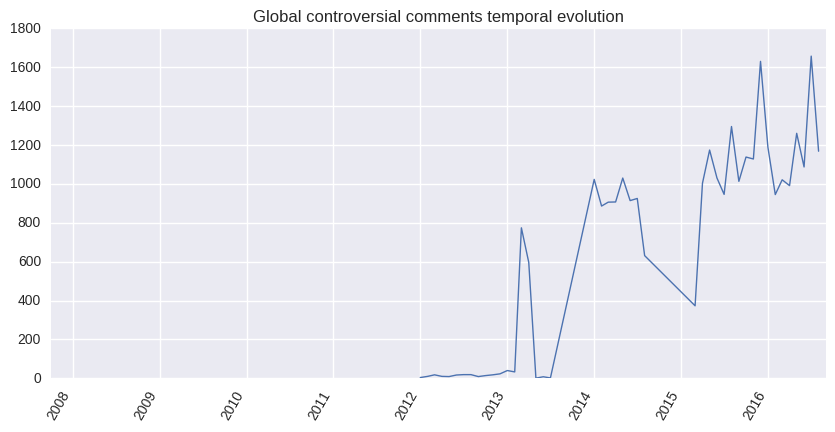

In [41]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Global controversial comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [42]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = controversial_df['body'].str.count(k).sum()

CPU times: user 1.85 s, sys: 4.24 ms, total: 1.85 s
Wall time: 1.85 s


In [43]:
keywords_counter = Counter(keywords_dict)

In [44]:
keywords_counter.most_common()

[('star trek', 10435),
 ('kirk', 3507),
 ('orion', 2745),
 ('mccoy', 2236),
 ('pike', 1697),
 ('vulcan', 1673),
 ('spock', 1216),
 ('picard', 1151),
 ('nero', 1030),
 ('klingon', 816),
 ('scotty', 770),
 ('crusher', 752),
 ('sulu', 420),
 ('romulan', 333),
 ('prime directive', 248),
 ('resistance is futile', 235),
 ('uhura', 183),
 ('chekhov', 151),
 ('the needs of the many outweigh the needs of the few', 94),
 ('live long and prosper', 83),
 ('star fleet', 74),
 ('llap', 70),
 ('highly illogical', 64),
 ('starship enterprise', 43),
 ('kobayashi maru', 37),
 ('khaaa+n', 35),
 ('beam me up,? scotty', 34),
 ('to boldly go where no man has gone before', 8),
 ('stardate', 8),
 ("i'm a doctor,? not a", 8),
 ('transporter beam', 6),
 ('nuclear wessels', 5),
 ('delta vega', 5),
 ('sarek', 5),
 ('set phasers to stun', 4),
 ('space,? the final frontier', 3),
 ('vulcan salute', 3),
 ('nurse chapel', 2),
 ("i'm giving her all she's got,? captain", 2),
 ('without followers,? evil cannot spread', 0

In [45]:
keywords_sr = pd.Series(keywords_dict)

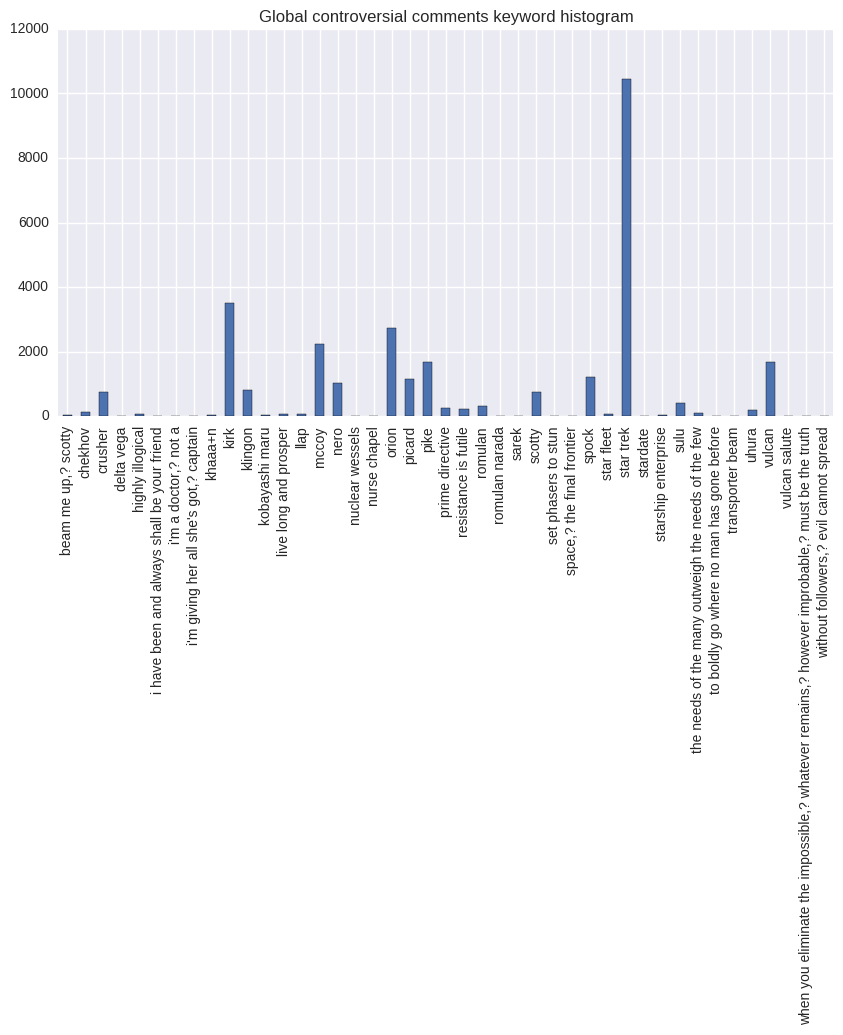

In [46]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Global controversial comments keyword histogram',
)

### Top

In [47]:
top_scored_controversial = controversial_df.sort_values(['score'], ascending=False)[:len(controversial_df) * P // 100]

In [48]:
len(top_scored_controversial)

2889

In [49]:
top_scored_controversial.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
1832015,kn0thing,we don’t talk about individual employees out o...,1,2015-07-06 13:45:21,admin,0.0,0,csu0kmv,t1_csu0kmv,t1_csu0bko,745,announcements,745,2015-07-01,2015-01-01
2169123,CustosClavium,vote conservative. go to mass and am faithful ...,1,2015-12-22 11:04:08,0,0,1,cy7up7u,0,t3_3xtw78,298,AskReddit,298,2015-12-01,2015-01-01
1888675,CIearMind,star wars and star trek are the same thing,1,2015-08-07 07:55:32,0,0,0,ctuortd,0,t3_3g4blw,212,AskReddit,212,2015-08-01,2015-01-01
2592059,osomeansbear,"yes, let's trust the uc davis equivalent of th...",1,2016-07-28 04:05:37,0,0,0,d5u6p9g,0,t1_d5u516m,136,pics,136,2016-07-01,2016-01-01
2146977,mrgeologyguy,oh please. all the star trek films since aroun...,1,2015-12-14 11:47:59,0,0,0,cxysm6d,0,t1_cxyrqur,132,movies,132,2015-12-01,2015-01-01


In [50]:
top_scored_controversial.ix[1832015]['body']

"we don’t talk about individual employees out of respect for their privacy. -  - with our announcement on friday, we're phasing out our role being in-between interesting people and the reddit audience so that we can focus on helping remarkable people become redditors, not just stop by on a press tour. -  - the responsibilities of our talent relations team going forward is about integrating celebrities, politicians, and noteworthy people as consistent posters (like arnold, snoop, or bernie sanders {edit: or [captain kirk](http://reddit.com/user/williamshatner)}) rather than one off occurrences. instead of just working with them once a year to promote something via ama, we want to be a resource to help them to actually join the reddit community ([arnold does this remarkably well](https://np.reddit.com/r/movies/comments/3bu70z/watching_terminator_genesys_with_my_father_some/cspq0lo)). -  - we're still introducing and sourcing talent for amas, just now giving the moderators the autonomy to

#### Temporal evolution

In [51]:
df_by_month = pd.Series(top_scored_controversial.groupby('month')['id'].count())
df_by_month.index.name = None

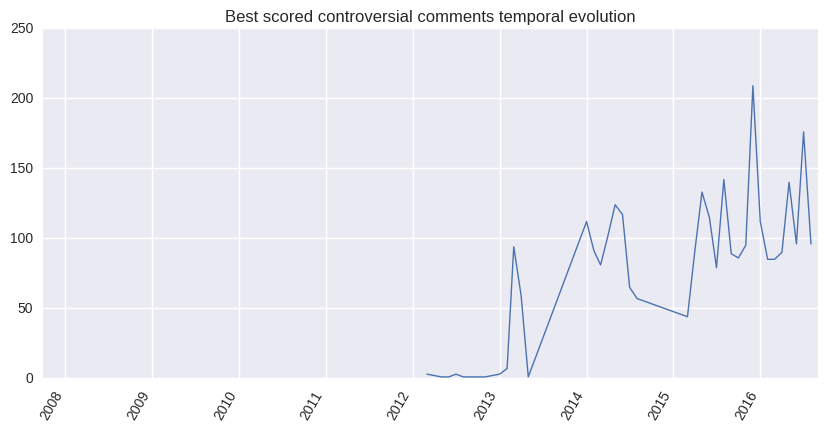

In [52]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Best scored controversial comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [53]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = top_scored_controversial['body'].str.count(k).sum()

CPU times: user 227 ms, sys: 0 ns, total: 227 ms
Wall time: 223 ms


In [54]:
keywords_counter = Counter(keywords_dict)

In [55]:
keywords_counter.most_common()

[('star trek', 1279),
 ('kirk', 319),
 ('orion', 255),
 ('mccoy', 209),
 ('pike', 168),
 ('spock', 166),
 ('vulcan', 130),
 ('picard', 91),
 ('nero', 90),
 ('crusher', 69),
 ('klingon', 67),
 ('sulu', 56),
 ('scotty', 50),
 ('prime directive', 30),
 ('uhura', 22),
 ('chekhov', 21),
 ('resistance is futile', 17),
 ('romulan', 15),
 ('llap', 15),
 ('live long and prosper', 13),
 ('highly illogical', 9),
 ('the needs of the many outweigh the needs of the few', 7),
 ('starship enterprise', 7),
 ('star fleet', 4),
 ('beam me up,? scotty', 4),
 ('kobayashi maru', 2),
 ('to boldly go where no man has gone before', 1),
 ('khaaa+n', 1),
 ('set phasers to stun', 1),
 ('space,? the final frontier', 1),
 ('vulcan salute', 1),
 ('delta vega', 1),
 ('without followers,? evil cannot spread', 0),
 ('transporter beam', 0),
 ('nuclear wessels', 0),
 ('romulan narada', 0),
 ('i have been and always shall be your friend', 0),
 ('stardate', 0),
 ('nurse chapel', 0),
 ("i'm giving her all she's got,? captai

In [56]:
keywords_sr = pd.Series(keywords_dict)

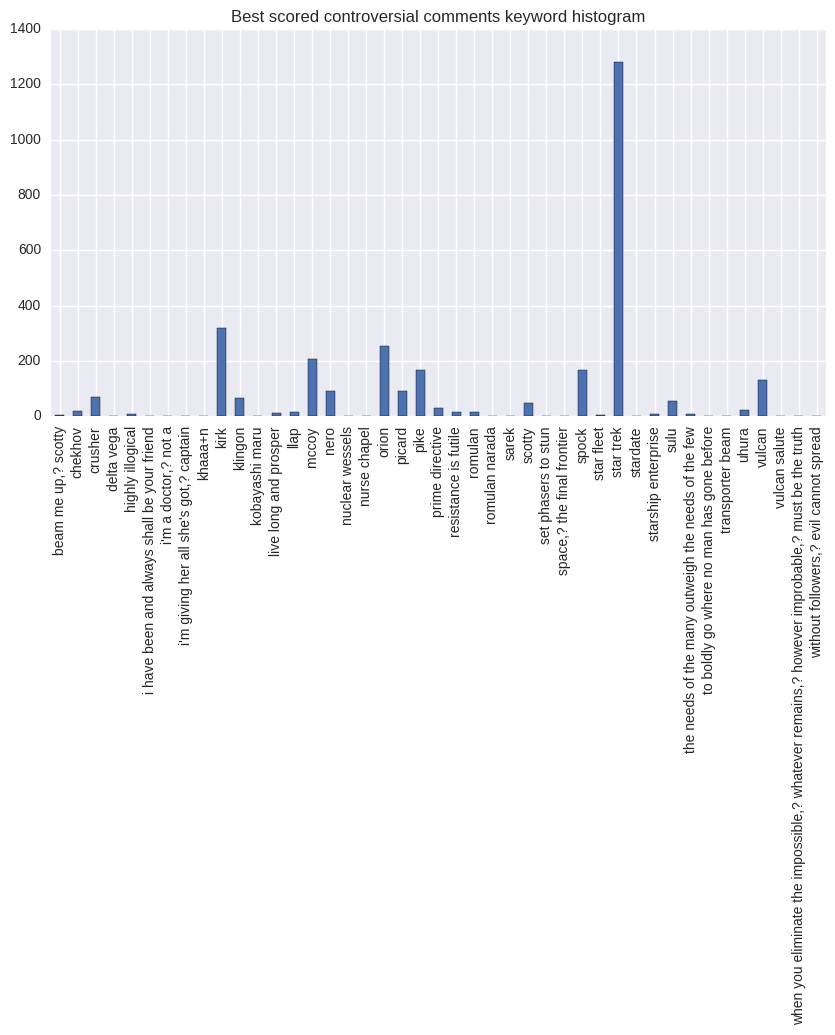

In [57]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Best scored controversial comments keyword histogram',
)

### Bottom

In [58]:
bottom_scored_controversial = controversial_df.sort_values(['score'], ascending=True)[:len(controversial_df) * P // 100]

In [59]:
len(bottom_scored_controversial)

2889

In [60]:
bottom_scored_controversial.head()

,author,body,controversiality,created_utc,distinguished,downs,gilded,id,name,parent_id,score,subreddit,ups,month,year
2351321,SuckNFail,i'm going to repost it next week with this title.,1,2016-03-27 16:13:56,0,0,0,d1fjyml,0,t1_d1fc0c2,-64,AdviceAnimals,-64,2016-03-01,2016-01-01
2647448,canttrustacracker,i'll never understand the white mentality. lie...,1,2016-08-22 02:45:00,0,0,0,d6rksgu,0,t3_4yys0e,-64,4chan,-64,2016-08-01,2016-01-01
970001,Nickster93,yeah he already knew that. - edit 2: .......,1,2014-02-16 15:28:25,0,0.0,0,cfgwgoh,t1_cfgwgoh,t1_cfgw9rh,-62,AdviceAnimals,-62,2014-02-01,2014-01-01
2158127,djb85511,ahem bernie sanders 2016,1,2015-12-17 20:32:21,0,0,0,cy2wvq9,0,t1_cy2wutm,-46,AdviceAnimals,-46,2015-12-01,2015-01-01
2560744,Jewbaccah,no it's not boring. in fact that's exactly wha...,1,2016-07-16 11:44:45,0,0,0,d5emef1,0,t1_d5em7oz,-39,movies,-39,2016-07-01,2016-01-01


In [61]:
bottom_scored_controversial.ix[2351321]['body']

"i'm going to repost it next week with this title."

#### Temporal evolution

In [62]:
df_by_month = pd.Series(bottom_scored_controversial.groupby('month')['id'].count())
df_by_month.index.name = None

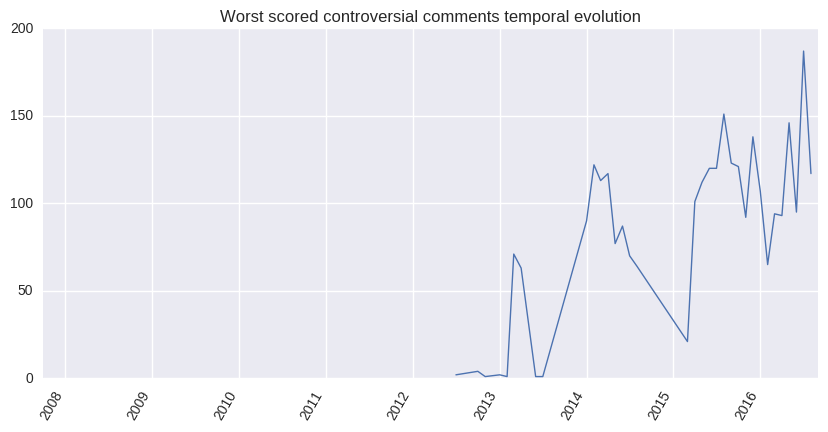

In [63]:
ax = df_by_month.plot(
    figsize=(10, 5),
    xlim=('2007-10-01', '2016-08-31'),
#     xticks=valid_dates,
    rot=60,
    title='Worst scored controversial comments temporal evolution',
)
# ax.set_xticklabels(show_dates);

#### Histogram

In [64]:
%%time

keywords_dict = {}
for k in keywords:
    keywords_dict[k] = bottom_scored_controversial['body'].str.count(k).sum()

CPU times: user 259 ms, sys: 243 µs, total: 259 ms
Wall time: 257 ms


In [65]:
keywords_counter = Counter(keywords_dict)

In [66]:
keywords_counter.most_common()

[('star trek', 985),
 ('kirk', 331),
 ('mccoy', 237),
 ('orion', 220),
 ('vulcan', 141),
 ('pike', 136),
 ('spock', 105),
 ('nero', 104),
 ('picard', 94),
 ('scotty', 65),
 ('crusher', 60),
 ('sulu', 57),
 ('klingon', 47),
 ('resistance is futile', 32),
 ('uhura', 20),
 ('romulan', 19),
 ('prime directive', 18),
 ('live long and prosper', 9),
 ('the needs of the many outweigh the needs of the few', 9),
 ('chekhov', 8),
 ('highly illogical', 8),
 ('star fleet', 7),
 ('llap', 5),
 ('beam me up,? scotty', 4),
 ('starship enterprise', 4),
 ('kobayashi maru', 3),
 ('khaaa+n', 2),
 ('to boldly go where no man has gone before', 1),
 ('set phasers to stun', 1),
 ('space,? the final frontier', 1),
 ('delta vega', 1),
 ("i'm a doctor,? not a", 1),
 ('without followers,? evil cannot spread', 0),
 ('transporter beam', 0),
 ('nuclear wessels', 0),
 ('romulan narada', 0),
 ('i have been and always shall be your friend', 0),
 ('stardate', 0),
 ('nurse chapel', 0),
 ("i'm giving her all she's got,? ca

In [67]:
keywords_sr = pd.Series(keywords_dict)

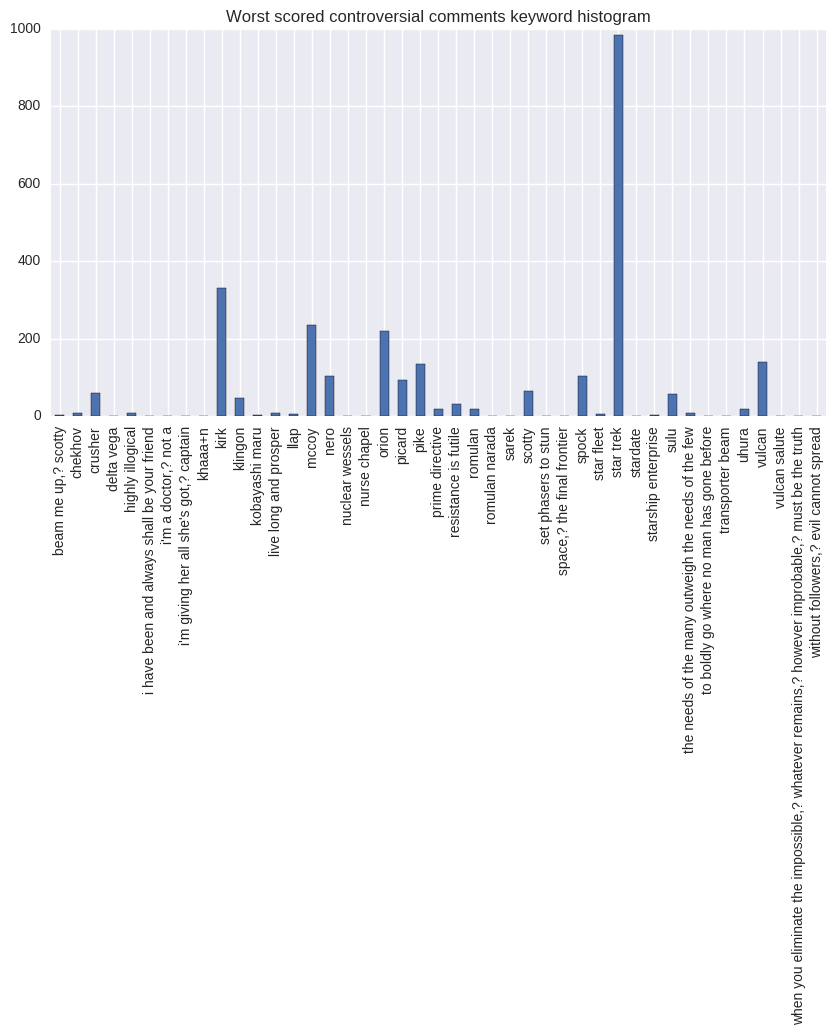

In [68]:
keywords_sr.plot(
    kind='bar',
    figsize=(10, 5),
    title='Worst scored controversial comments keyword histogram',
)